Here we fit models across fish, looking at the latent representations of different conditions for all fish in the same 
low-d space

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import chain
from pathlib import Path

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
import torch

import sklearn.decomposition as decomposition

from ahrens_wbo.annotations import label_subperiods
from ahrens_wbo.data_processing import load_and_preprocess_data
from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.image_generation import max_project_pts
from janelia_core.visualization.image_generation import generate_dot_image_3d
from janelia_core.visualization.image_generation import scalar_3d_max_project
from janelia_core.visualization.matrix_visualization import cmp_n_mats
from probabilistic_model_synthesis.fa import FAMdl
from probabilistic_model_synthesis.fa import Fitter
from probabilistic_model_synthesis.fa import generate_basic_posteriors
from probabilistic_model_synthesis.fa import generate_hypercube_prior_collection
from probabilistic_model_synthesis.fa import generate_simple_prior_collection
from probabilistic_model_synthesis.fa import initialize_basic_posteriors
from probabilistic_model_synthesis.fa import orthonormalize
from probabilistic_model_synthesis.fa import VICollection

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
ps = dict()

# Specify the directory where all the raw data is found
ps['data_dir'] = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data'

# Here we list the subject we want to fit and the conditions we want to fit on for each subject
#ps['fit_specs'] = {8: ['omr_forward', 'omr_left', 'omr_right'], 
#                   9: ['omr_forward', 'omr_left', 'omr_right'], 
#                   10: ['omr_forward', 'omr_left', 'omr_right'], 
#                   11: ['omr_forward', 'omr_left', 'omr_right']} 


ps['fit_specs'] = {1: ['phototaxis_left', 'phototaxis_right'],
                   2: ['phototaxis_left', 'phototaxis_right'],
                   5: ['phototaxis_left', 'phototaxis_right'],
                   6: ['phototaxis_left', 'phototaxis_right'], 
                   8: ['phototaxis_left', 'phototaxis_right'],
                   9: ['phototaxis_left', 'phototaxis_right'],
                   10: ['phototaxis_left', 'phototaxis_right'],
                   11: ['phototaxis_left', 'phototaxis_right']}
                   
                   
# Here we specify if we fit in conditions with shock or not
ps['shock'] = False

# Specify the number of latent variables in the FA models
ps['n_latent_vars'] = 10

## Load the data for each subject

In [5]:
datasets, neuron_locs = load_and_preprocess_data(data_folder=ps['data_dir'], 
                                    subjects=list(ps['fit_specs'].keys()), 
                                                 neural_gain=10)

Done loading data for subject subject_1.
Done loading data for subject subject_2.
Done loading data for subject subject_5.
Done loading data for subject subject_6.
Done loading data for subject subject_8.
Done loading data for subject subject_9.
Done loading data for subject subject_10.
Done loading data for subject subject_11.


## Form the fitting data for each subject

In [6]:
all_subperiods = set(chain(*[v for v in ps['fit_specs'].values()]))
label_map = {sp: sp_i for sp_i, sp in enumerate(all_subperiods)}

In [7]:
fit_data = dict()
fit_labels = dict()
for s_n, dataset in datasets.items():
    
    data_n = datasets[s_n].ts_data['dff']['vls'][:]
    
    # Label the subperiods for this subject
    subperiods = label_subperiods(dataset.ts_data['stim']['vls'][:])
    
    # Down select to only the subperiods we want to fit on for this subject
    subperiods = {k:v for k, v in subperiods.items() if k in ps['fit_specs'][s_n]}
    
    # Down select to the shock condition we want to fit
    subperiods = {k: [sp_i for sp_i in v if sp_i['shock'] == ps['shock']] for k, v in subperiods.items()} 
    
    # Pull out the fitting data for this subject
    fit_data[s_n] = {k:np.concatenate([data_n[sl['slice'], :] for sl in v], axis=0) for k, v in subperiods.items()}
    
    # Generate numerical labels for each data point
    fit_labels[s_n] = {k:label_map[k]*np.ones(np.sum([sl_i['slice'].stop - sl_i['slice'].start for sl_i in v])) 
                   for k, v in subperiods.items()}
    

In [8]:
fit_data_conc = {k: np.concatenate([data for data in v.values()], axis=0) for k, v in fit_data.items()}
fit_labels_conc = {k: np.concatenate([lbls for lbls in v.values()], axis=0) for k, v in fit_labels.items()}

## Setup everything for fitting FA models together

In [9]:
fit_priors = generate_hypercube_prior_collection(n_latent_vars=ps['n_latent_vars'], 
                                                 hc_params={'n_divisions_per_dim': [20, 20, 10], 
                                                            'dim_ranges': np.asarray([[0, 990.0], 
                                                                                      [0, 610.0], 
                                                                                      [0, 350.0]]),
                                                            'n_div_per_hc_side_per_dim': [1, 1, 1]}, 
                                                 lm_mn_init=0.0,
                                                 lm_std_init=1.0, 
                                                 mn_mn_init=0.0, 
                                                 mn_std_init=1.0, 
                                                 psi_conc_vl_init=.2,
                                                 psi_rate_vl_init=.1,
                                                 min_gamma_conc_vl=.1,
                                                 min_gamma_rate_vl=.000001)
                                                 

fit_posteriors = generate_basic_posteriors(n_obs_vars=[data_n.shape[1] for data_n in fit_data_conc.values()],
                                           n_smps=[data_n.shape[0] for data_n in fit_data_conc.values()],
                                           n_latent_vars=ps['n_latent_vars'], 
                                           mn_opts={'std_ub': 10000.0}, 
                                           lm_opts={'std_ub': 10000.0},
                                           psi_opts={'alpha_lb': .1, 'beta_lb': .000001})

fit_posteriors = {k: fit_posteriors[k_i] for k_i, k in enumerate(fit_data_conc.keys())}


fit_mdls = {k:FAMdl(lm=None, #torch.zeros(data_n.shape[1], ps['n_latent_vars']), 
                    mn=None, #torch.zeros(data_n.shape[1]),
                    psi=None) for k, data_n in fit_data_conc.items()} #.01*torch.ones(data_n.shape[1]))
                    
                    
                   
vi_collections = [VICollection(data=torch.tensor(fit_data_conc[s_n]), 
                               props=neuron_locs[s_n],
                               mdl = fit_mdls[s_n],
                               posteriors = fit_posteriors[s_n])
                               for s_i, s_n in enumerate(fit_data_conc.keys())]


## Initialize posteriors

In [10]:
subjects = list(ps['fit_specs'].keys())
initialize_basic_posteriors(posteriors=[fit_posteriors[s_n] for s_n in subjects],
                                  data=[fit_data_conc[s_n] for s_n in subjects])

Done initializing posteriors for model 1 of 8.
Done initializing posteriors for model 2 of 8.
Done initializing posteriors for model 3 of 8.
Done initializing posteriors for model 4 of 8.
Done initializing posteriors for model 5 of 8.
Done initializing posteriors for model 6 of 8.
Done initializing posteriors for model 7 of 8.
Done initializing posteriors for model 8 of 8.


## Initialize priors

In [11]:
devices, _ = list_torch_devices()

Found 1 GPUs


In [12]:
fitter = Fitter(vi_collections=vi_collections, priors=fit_priors)

In [13]:
fitter.distribute(distribute_data=True, devices=devices)

In [14]:
prior_opt_log = fitter.optimize_priors(1000, milestones=[500, 700], update_int=100, init_lr=.01)


=========== EPOCH 0 COMPLETE ===========
Obj: 4.58e+07
----------------------------------------
LM KL: 4.42e+06, 4.67e+06, 5.86e+06, 5.36e+06, 3.90e+06, 4.48e+06, 4.47e+06, 5.70e+06
Mn KL: 3.94e+05, 4.01e+05, 4.90e+05, 4.56e+05, 3.44e+05, 3.80e+05, 3.93e+05, 4.79e+05
Psi KL: 4.36e+05, 4.32e+05, 5.24e+05, 4.90e+05, 3.67e+05, 4.10e+05, 4.44e+05, 5.00e+05
----------------------------------------
LR: 0.01
Elapsed time (secs): 0.40062665939331055
----------------------------------------
CPU cur memory used (GB): 4.95e+01
GPU_0 cur memory used (GB): 3.10e+00, max memory used (GB): 3.10e+00

=========== EPOCH 100 COMPLETE ===========
Obj: 2.25e+07
----------------------------------------
LM KL: 1.89e+06, 2.15e+06, 2.86e+06, 2.58e+06, 1.84e+06, 2.16e+06, 2.00e+06, 2.64e+06
Mn KL: 2.47e+05, 1.96e+05, 3.24e+05, 2.40e+05, 2.00e+05, 1.85e+05, 1.94e+05, 2.57e+05
Psi KL: 3.00e+05, 2.99e+05, 3.75e+05, 3.49e+05, 2.63e+05, 2.92e+05, 3.25e+05, 3.57e+05
----------------------------------------
LR: 0.01


#### Look at log for prior optimizatiom

In [15]:
fitter.plot_log(prior_opt_log)

[True, False, False, True, True, True]


<IPython.core.display.Javascript object>

## Fit the models together

In [16]:
fitter.distribute(distribute_data=True, devices=devices)

In [17]:
log = fitter.fit(1000, milestones=[300, 500, 700], update_int=2, init_lr=.1, 
                 skip_lm_kl=False, skip_mn_kl=False, skip_psi_kl=False)


=========== EPOCH 0 COMPLETE ===========
Obj: nan
----------------------------------------
NELL: 3.10e+08, 1.46e+08, 2.25e+08, 3.45e+08, 1.78e+08, 8.71e+07, 5.46e+07, 1.82e+08
Latent KL: nan, nan, nan, nan, nan, 3.96e+02, nan, nan
LM KL: 7.75e+06, 1.25e+07, 1.92e+07, 1.06e+07, 9.01e+06, 3.83e+07, 8.07e+06, 1.94e+07
Mn KL: 9.58e+05, 3.20e+05, 5.73e+05, 3.70e+05, 6.21e+05, 2.99e+05, 4.48e+05, 4.01e+05
Psi KL: 2.51e+05, 2.40e+05, 3.13e+05, 2.86e+05, 2.19e+05, 2.36e+05, 2.70e+05, 2.87e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 2.068666934967041
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 2 COMPLETE ===========
Obj: 1.54e+09
----------------------------------------
NELL: 2.98e+08, 1.40e+08, 2.15e+08, 3.29e+08, 1.72e+08, 8.42e+07, 5.20e+07, 1.74e+08
Latent KL: 5.32e+03, 2.96e+03, 6.02e+03, 4.24e+03, 4.19e+03, 1.35e+03, 3.22e+02, 2.48e+03
LM K


=========== EPOCH 22 COMPLETE ===========
Obj: 1.15e+09
----------------------------------------
NELL: 2.17e+08, 1.12e+08, 1.73e+08, 2.60e+08, 1.37e+08, 6.56e+07, 3.70e+07, 1.33e+08
Latent KL: 4.60e+04, 2.57e+04, 4.25e+04, 6.86e+04, 4.10e+04, 1.47e+04, 7.74e+03, 2.81e+04
LM KL: 2.59e+06, 1.38e+06, 1.77e+06, 1.93e+06, 1.53e+06, 8.12e+05, 9.24e+05, 1.84e+06
Mn KL: 2.70e+05, 2.39e+05, 3.05e+05, 3.05e+05, 2.11e+05, 2.19e+05, 2.14e+05, 2.94e+05
Psi KL: 2.48e+05, 2.30e+05, 3.02e+05, 2.74e+05, 2.15e+05, 2.26e+05, 2.59e+05, 2.74e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 26.94925045967102
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 24 COMPLETE ===========
Obj: 1.14e+09
----------------------------------------
NELL: 2.13e+08, 1.12e+08, 1.71e+08, 2.58e+08, 1.35e+08, 6.40e+07, 3.59e+07, 1.30e+08
Latent KL: 4.79e+04, 2.56e+04, 4.51e+04, 6.87e+04, 4


=========== EPOCH 44 COMPLETE ===========
Obj: 1.08e+09
----------------------------------------
NELL: 2.02e+08, 1.05e+08, 1.65e+08, 2.50e+08, 1.31e+08, 5.92e+07, 3.06e+07, 1.23e+08
Latent KL: 5.69e+04, 3.01e+04, 4.82e+04, 6.06e+04, 4.15e+04, 1.56e+04, 1.13e+04, 2.64e+04
LM KL: 1.98e+06, 1.46e+06, 1.73e+06, 1.83e+06, 1.37e+06, 1.24e+06, 1.26e+06, 1.73e+06
Mn KL: 2.71e+05, 2.25e+05, 2.83e+05, 2.86e+05, 1.99e+05, 1.96e+05, 1.96e+05, 2.73e+05
Psi KL: 2.45e+05, 2.23e+05, 2.95e+05, 2.66e+05, 2.11e+05, 2.19e+05, 2.52e+05, 2.65e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 51.80415725708008
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 46 COMPLETE ===========
Obj: 1.08e+09
----------------------------------------
NELL: 2.02e+08, 1.05e+08, 1.65e+08, 2.50e+08, 1.31e+08, 5.90e+07, 3.05e+07, 1.22e+08
Latent KL: 5.64e+04, 3.03e+04, 4.51e+04, 6.40e+04, 3


=========== EPOCH 66 COMPLETE ===========
Obj: 1.09e+09
----------------------------------------
NELL: 2.01e+08, 1.05e+08, 1.64e+08, 2.61e+08, 1.30e+08, 5.78e+07, 3.03e+07, 1.22e+08
Latent KL: 5.03e+04, 3.09e+04, 4.56e+04, 7.83e+04, 4.37e+04, 1.93e+04, 1.01e+04, 3.05e+04
LM KL: 1.93e+06, 1.44e+06, 1.63e+06, 2.29e+06, 1.35e+06, 1.18e+06, 1.20e+06, 1.66e+06
Mn KL: 2.61e+05, 2.15e+05, 2.62e+05, 2.67e+05, 1.93e+05, 1.84e+05, 1.87e+05, 2.56e+05
Psi KL: 2.44e+05, 2.17e+05, 2.90e+05, 2.60e+05, 2.08e+05, 2.13e+05, 2.47e+05, 2.58e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 76.77218222618103
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 68 COMPLETE ===========
Obj: 1.08e+09
----------------------------------------
NELL: 2.01e+08, 1.05e+08, 1.64e+08, 2.57e+08, 1.30e+08, 5.77e+07, 3.03e+07, 1.22e+08
Latent KL: 5.26e+04, 2.96e+04, 4.58e+04, 7.43e+04, 4


=========== EPOCH 88 COMPLETE ===========
Obj: 1.08e+09
----------------------------------------
NELL: 2.01e+08, 1.04e+08, 1.65e+08, 2.50e+08, 1.30e+08, 5.81e+07, 3.03e+07, 1.21e+08
Latent KL: 5.06e+04, 3.62e+04, 4.44e+04, 8.19e+04, 4.84e+04, 1.68e+04, 1.02e+04, 2.86e+04
LM KL: 1.94e+06, 1.36e+06, 1.60e+06, 2.17e+06, 1.34e+06, 1.15e+06, 1.22e+06, 1.62e+06
Mn KL: 2.56e+05, 2.12e+05, 2.55e+05, 2.61e+05, 1.92e+05, 1.81e+05, 1.85e+05, 2.51e+05
Psi KL: 2.43e+05, 2.13e+05, 2.86e+05, 2.55e+05, 2.07e+05, 2.09e+05, 2.43e+05, 2.53e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 101.60339021682739
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 90 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 2.01e+08, 1.04e+08, 1.65e+08, 2.49e+08, 1.30e+08, 5.79e+07, 3.03e+07, 1.21e+08
Latent KL: 5.39e+04, 3.66e+04, 3.85e+04, 8.35e+04, 


=========== EPOCH 110 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 2.00e+08, 1.04e+08, 1.67e+08, 2.48e+08, 1.30e+08, 5.73e+07, 3.00e+07, 1.21e+08
Latent KL: 5.66e+04, 3.77e+04, 4.00e+04, 8.68e+04, 4.68e+04, 1.92e+04, 1.08e+04, 3.63e+04
LM KL: 1.93e+06, 1.33e+06, 1.64e+06, 1.84e+06, 1.33e+06, 1.15e+06, 1.24e+06, 1.63e+06
Mn KL: 2.57e+05, 2.11e+05, 2.53e+05, 2.56e+05, 1.93e+05, 1.80e+05, 1.85e+05, 2.49e+05
Psi KL: 2.43e+05, 2.09e+05, 2.83e+05, 2.51e+05, 2.05e+05, 2.05e+05, 2.39e+05, 2.48e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 126.58977675437927
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 112 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 2.00e+08, 1.04e+08, 1.66e+08, 2.48e+08, 1.30e+08, 5.72e+07, 3.00e+07, 1.21e+08
Latent KL: 5.95e+04, 3.78e+04, 4.27e+04, 8.77e+04


=========== EPOCH 132 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 2.00e+08, 1.04e+08, 1.64e+08, 2.48e+08, 1.30e+08, 5.73e+07, 3.03e+07, 1.20e+08
Latent KL: 5.46e+04, 3.71e+04, 5.42e+04, 9.02e+04, 4.96e+04, 1.97e+04, 1.05e+04, 3.74e+04
LM KL: 1.90e+06, 1.31e+06, 1.65e+06, 1.78e+06, 1.32e+06, 1.12e+06, 1.21e+06, 1.59e+06
Mn KL: 2.58e+05, 2.10e+05, 2.53e+05, 2.57e+05, 1.92e+05, 1.80e+05, 1.85e+05, 2.49e+05
Psi KL: 2.43e+05, 2.06e+05, 2.80e+05, 2.48e+05, 2.05e+05, 2.02e+05, 2.36e+05, 2.44e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 151.46558332443237
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 134 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 2.00e+08, 1.04e+08, 1.64e+08, 2.48e+08, 1.30e+08, 5.75e+07, 3.02e+07, 1.20e+08
Latent KL: 5.60e+04, 3.77e+04, 5.66e+04, 8.98e+04


=========== EPOCH 154 COMPLETE ===========
Obj: 1.08e+09
----------------------------------------
NELL: 1.99e+08, 1.04e+08, 1.63e+08, 2.48e+08, 1.37e+08, 5.73e+07, 2.99e+07, 1.20e+08
Latent KL: 6.69e+04, 3.72e+04, 6.03e+04, 9.03e+04, 3.69e+04, 1.57e+04, 1.07e+04, 3.37e+04
LM KL: 1.92e+06, 1.29e+06, 1.58e+06, 1.74e+06, 1.32e+06, 1.15e+06, 1.23e+06, 1.56e+06
Mn KL: 2.59e+05, 2.09e+05, 2.52e+05, 2.57e+05, 1.92e+05, 1.80e+05, 1.85e+05, 2.48e+05
Psi KL: 2.43e+05, 2.03e+05, 2.78e+05, 2.45e+05, 2.04e+05, 1.99e+05, 2.34e+05, 2.41e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 176.42931270599365
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 156 COMPLETE ===========
Obj: 1.08e+09
----------------------------------------
NELL: 1.99e+08, 1.04e+08, 1.63e+08, 2.48e+08, 1.38e+08, 5.73e+07, 2.99e+07, 1.25e+08
Latent KL: 6.65e+04, 3.78e+04, 6.09e+04, 8.95e+04


=========== EPOCH 176 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 1.99e+08, 1.04e+08, 1.63e+08, 2.48e+08, 1.30e+08, 5.71e+07, 3.17e+07, 1.21e+08
Latent KL: 6.60e+04, 3.46e+04, 6.10e+04, 9.00e+04, 3.91e+04, 1.78e+04, 9.39e+03, 2.65e+04
LM KL: 1.90e+06, 1.28e+06, 1.54e+06, 1.71e+06, 1.52e+06, 1.13e+06, 1.19e+06, 1.68e+06
Mn KL: 2.58e+05, 2.07e+05, 2.52e+05, 2.56e+05, 1.94e+05, 1.80e+05, 1.85e+05, 2.47e+05
Psi KL: 2.43e+05, 2.00e+05, 2.76e+05, 2.42e+05, 2.04e+05, 1.96e+05, 2.31e+05, 2.38e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 201.30200862884521
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 178 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 1.99e+08, 1.04e+08, 1.63e+08, 2.48e+08, 1.30e+08, 5.72e+07, 3.14e+07, 1.21e+08
Latent KL: 6.59e+04, 3.43e+04, 6.11e+04, 8.97e+04


=========== EPOCH 198 COMPLETE ===========
Obj: 1.08e+09
----------------------------------------
NELL: 1.99e+08, 1.04e+08, 1.69e+08, 2.47e+08, 1.29e+08, 5.70e+07, 3.01e+07, 1.22e+08
Latent KL: 6.56e+04, 2.82e+04, 4.03e+04, 9.03e+04, 5.30e+04, 1.93e+04, 9.78e+03, 2.31e+04
LM KL: 1.89e+06, 1.26e+06, 1.87e+06, 1.69e+06, 1.36e+06, 1.10e+06, 1.24e+06, 1.59e+06
Mn KL: 2.57e+05, 2.06e+05, 2.53e+05, 2.56e+05, 1.92e+05, 1.80e+05, 1.85e+05, 2.46e+05
Psi KL: 2.44e+05, 1.98e+05, 2.74e+05, 2.40e+05, 2.03e+05, 1.94e+05, 2.29e+05, 2.35e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 226.1412079334259
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 200 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 1.99e+08, 1.04e+08, 1.68e+08, 2.47e+08, 1.29e+08, 5.70e+07, 3.01e+07, 1.22e+08
Latent KL: 6.55e+04, 2.79e+04, 3.68e+04, 8.99e+04,


=========== EPOCH 220 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 1.98e+08, 1.04e+08, 1.65e+08, 2.48e+08, 1.29e+08, 5.77e+07, 2.99e+07, 1.21e+08
Latent KL: 6.58e+04, 2.86e+04, 4.20e+04, 8.15e+04, 5.34e+04, 1.57e+04, 9.91e+03, 2.87e+04
LM KL: 1.89e+06, 1.31e+06, 1.65e+06, 1.66e+06, 1.31e+06, 1.13e+06, 1.21e+06, 1.71e+06
Mn KL: 2.56e+05, 2.06e+05, 2.53e+05, 2.56e+05, 1.92e+05, 1.80e+05, 1.86e+05, 2.46e+05
Psi KL: 2.45e+05, 1.96e+05, 2.73e+05, 2.38e+05, 2.03e+05, 1.92e+05, 2.28e+05, 2.33e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 251.12464714050293
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 222 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 1.98e+08, 1.04e+08, 1.65e+08, 2.48e+08, 1.29e+08, 5.75e+07, 2.99e+07, 1.21e+08
Latent KL: 6.56e+04, 2.60e+04, 4.61e+04, 7.87e+04


=========== EPOCH 242 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 1.98e+08, 1.04e+08, 1.64e+08, 2.47e+08, 1.29e+08, 5.71e+07, 2.99e+07, 1.22e+08
Latent KL: 6.58e+04, 3.04e+04, 4.68e+04, 8.43e+04, 5.31e+04, 1.90e+04, 1.05e+04, 2.50e+04
LM KL: 1.88e+06, 1.30e+06, 1.63e+06, 1.65e+06, 1.29e+06, 1.13e+06, 1.20e+06, 1.60e+06
Mn KL: 2.55e+05, 2.05e+05, 2.52e+05, 2.56e+05, 1.92e+05, 1.80e+05, 1.86e+05, 2.46e+05
Psi KL: 2.45e+05, 1.94e+05, 2.71e+05, 2.36e+05, 2.03e+05, 1.90e+05, 2.26e+05, 2.31e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 275.9716031551361
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 244 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 1.98e+08, 1.04e+08, 1.64e+08, 2.47e+08, 1.29e+08, 5.72e+07, 2.99e+07, 1.21e+08
Latent KL: 6.53e+04, 3.32e+04, 4.58e+04, 8.54e+04,


=========== EPOCH 264 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 1.98e+08, 1.05e+08, 1.66e+08, 2.47e+08, 1.29e+08, 5.69e+07, 3.00e+07, 1.20e+08
Latent KL: 6.49e+04, 2.76e+04, 3.73e+04, 9.11e+04, 5.31e+04, 1.99e+04, 1.01e+04, 3.11e+04
LM KL: 1.87e+06, 1.29e+06, 1.57e+06, 1.64e+06, 1.28e+06, 1.10e+06, 1.24e+06, 1.63e+06
Mn KL: 2.54e+05, 2.05e+05, 2.52e+05, 2.56e+05, 1.93e+05, 1.80e+05, 1.87e+05, 2.46e+05
Psi KL: 2.46e+05, 1.92e+05, 2.70e+05, 2.34e+05, 2.03e+05, 1.88e+05, 2.25e+05, 2.29e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 300.9086103439331
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 266 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 1.98e+08, 1.05e+08, 1.66e+08, 2.47e+08, 1.29e+08, 5.69e+07, 2.99e+07, 1.20e+08
Latent KL: 6.50e+04, 2.65e+04, 3.86e+04, 9.04e+04,


=========== EPOCH 286 COMPLETE ===========
Obj: 1.08e+09
----------------------------------------
NELL: 1.99e+08, 1.04e+08, 1.64e+08, 2.47e+08, 1.29e+08, 5.73e+07, 3.00e+07, 1.30e+08
Latent KL: 4.92e+04, 2.97e+04, 4.76e+04, 8.90e+04, 5.35e+04, 1.73e+04, 9.58e+03, 2.86e+04
LM KL: 1.85e+06, 1.32e+06, 1.64e+06, 1.63e+06, 1.27e+06, 1.13e+06, 1.19e+06, 1.57e+06
Mn KL: 2.53e+05, 2.04e+05, 2.52e+05, 2.56e+05, 1.93e+05, 1.81e+05, 1.87e+05, 2.46e+05
Psi KL: 2.47e+05, 1.91e+05, 2.69e+05, 2.32e+05, 2.03e+05, 1.87e+05, 2.23e+05, 2.27e+05
----------------------------------------
LR: 0.1
Elapsed time (secs): 325.7387783527374
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 288 COMPLETE ===========
Obj: 1.08e+09
----------------------------------------
NELL: 1.99e+08, 1.04e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.74e+07, 3.01e+07, 1.29e+08
Latent KL: 4.69e+04, 3.36e+04, 5.22e+04, 8.97e+04,


=========== EPOCH 308 COMPLETE ===========
Obj: 1.07e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.50e+08, 1.29e+08, 5.67e+07, 2.96e+07, 1.21e+08
Latent KL: 6.04e+04, 3.58e+04, 6.05e+04, 7.13e+04, 5.34e+04, 2.23e+04, 1.20e+04, 3.15e+04
LM KL: 1.82e+06, 1.26e+06, 1.56e+06, 1.67e+06, 1.26e+06, 1.09e+06, 1.18e+06, 1.89e+06
Mn KL: 2.53e+05, 2.04e+05, 2.51e+05, 2.56e+05, 1.92e+05, 1.80e+05, 1.87e+05, 2.46e+05
Psi KL: 2.47e+05, 1.90e+05, 2.69e+05, 2.31e+05, 2.03e+05, 1.86e+05, 2.22e+05, 2.26e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 350.56703877449036
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 310 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.50e+08, 1.29e+08, 5.67e+07, 2.96e+07, 1.21e+08
Latent KL: 6.40e+04, 3.50e+04, 6


=========== EPOCH 330 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.48e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.20e+08
Latent KL: 6.54e+04, 3.74e+04, 6.06e+04, 8.41e+04, 5.34e+04, 2.35e+04, 1.37e+04, 3.50e+04
LM KL: 1.80e+06, 1.23e+06, 1.53e+06, 1.71e+06, 1.24e+06, 1.06e+06, 1.15e+06, 1.78e+06
Mn KL: 2.52e+05, 2.02e+05, 2.49e+05, 2.54e+05, 1.91e+05, 1.78e+05, 1.85e+05, 2.43e+05
Psi KL: 2.47e+05, 1.90e+05, 2.68e+05, 2.31e+05, 2.03e+05, 1.85e+05, 2.22e+05, 2.26e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 375.4589579105377
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 332 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.48e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.20e+08
Latent KL: 6.52e+04, 3.73e+04, 6.


=========== EPOCH 352 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.48e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.20e+08
Latent KL: 6.54e+04, 3.73e+04, 6.06e+04, 8.45e+04, 5.35e+04, 2.34e+04, 1.36e+04, 3.59e+04
LM KL: 1.78e+06, 1.20e+06, 1.50e+06, 1.71e+06, 1.22e+06, 1.03e+06, 1.13e+06, 1.70e+06
Mn KL: 2.50e+05, 2.00e+05, 2.47e+05, 2.51e+05, 1.89e+05, 1.76e+05, 1.82e+05, 2.41e+05
Psi KL: 2.47e+05, 1.90e+05, 2.68e+05, 2.31e+05, 2.03e+05, 1.85e+05, 2.22e+05, 2.26e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 400.4926199913025
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 354 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.48e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.20e+08
Latent KL: 6.53e+04, 3.72e+04, 6.


=========== EPOCH 374 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.20e+08
Latent KL: 6.54e+04, 3.74e+04, 6.07e+04, 8.52e+04, 5.36e+04, 2.33e+04, 1.36e+04, 3.71e+04
LM KL: 1.76e+06, 1.19e+06, 1.48e+06, 1.71e+06, 1.21e+06, 1.02e+06, 1.12e+06, 1.64e+06
Mn KL: 2.48e+05, 1.99e+05, 2.45e+05, 2.49e+05, 1.88e+05, 1.75e+05, 1.81e+05, 2.39e+05
Psi KL: 2.47e+05, 1.89e+05, 2.68e+05, 2.31e+05, 2.03e+05, 1.85e+05, 2.22e+05, 2.26e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 425.6944315433502
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 376 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.20e+08
Latent KL: 6.54e+04, 3.74e+04, 6.


=========== EPOCH 396 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.73e+04, 6.06e+04, 8.65e+04, 5.36e+04, 2.34e+04, 1.37e+04, 3.77e+04
LM KL: 1.75e+06, 1.18e+06, 1.47e+06, 1.70e+06, 1.20e+06, 1.01e+06, 1.11e+06, 1.59e+06
Mn KL: 2.47e+05, 1.98e+05, 2.44e+05, 2.48e+05, 1.87e+05, 1.74e+05, 1.80e+05, 2.37e+05
Psi KL: 2.47e+05, 1.89e+05, 2.68e+05, 2.31e+05, 2.03e+05, 1.85e+05, 2.22e+05, 2.26e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 450.8146483898163
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 398 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.73e+04, 6.


=========== EPOCH 418 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.52e+04, 3.73e+04, 6.07e+04, 8.77e+04, 5.35e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.74e+06, 1.18e+06, 1.47e+06, 1.69e+06, 1.20e+06, 1.01e+06, 1.11e+06, 1.56e+06
Mn KL: 2.46e+05, 1.98e+05, 2.43e+05, 2.47e+05, 1.87e+05, 1.74e+05, 1.80e+05, 2.37e+05
Psi KL: 2.48e+05, 1.89e+05, 2.68e+05, 2.31e+05, 2.03e+05, 1.85e+05, 2.22e+05, 2.25e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 476.070303440094
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 420 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.53e+04, 3.73e+04, 6.0


=========== EPOCH 440 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 8.93e+04, 5.34e+04, 2.34e+04, 1.37e+04, 3.78e+04
LM KL: 1.74e+06, 1.17e+06, 1.46e+06, 1.69e+06, 1.20e+06, 1.00e+06, 1.10e+06, 1.53e+06
Mn KL: 2.46e+05, 1.97e+05, 2.43e+05, 2.47e+05, 1.86e+05, 1.74e+05, 1.80e+05, 2.36e+05
Psi KL: 2.48e+05, 1.89e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.85e+05, 2.22e+05, 2.25e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 500.90919256210327
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 442 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.73e+04, 6


=========== EPOCH 462 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.73e+04, 6.08e+04, 9.04e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.76e+04
LM KL: 1.73e+06, 1.17e+06, 1.46e+06, 1.68e+06, 1.20e+06, 9.99e+05, 1.10e+06, 1.51e+06
Mn KL: 2.45e+05, 1.97e+05, 2.43e+05, 2.46e+05, 1.86e+05, 1.74e+05, 1.79e+05, 2.36e+05
Psi KL: 2.48e+05, 1.89e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.85e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 525.7532432079315
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 464 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.98e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.52e+04, 3.72e+04, 6.


=========== EPOCH 484 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.73e+04, 6.09e+04, 9.07e+04, 5.33e+04, 2.34e+04, 1.37e+04, 3.78e+04
LM KL: 1.73e+06, 1.17e+06, 1.45e+06, 1.67e+06, 1.20e+06, 9.96e+05, 1.10e+06, 1.50e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.74e+05, 1.79e+05, 2.36e+05
Psi KL: 2.48e+05, 1.89e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 550.7414593696594
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 486 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.74e+04, 6.


=========== EPOCH 506 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.73e+04, 6.08e+04, 9.07e+04, 5.34e+04, 2.35e+04, 1.37e+04, 3.77e+04
LM KL: 1.73e+06, 1.17e+06, 1.45e+06, 1.67e+06, 1.20e+06, 9.93e+05, 1.10e+06, 1.49e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.74e+05, 1.79e+05, 2.36e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.0010000000000000002
Elapsed time (secs): 575.5887250900269
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 508 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.73e+04, 6


=========== EPOCH 528 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.35e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.73e+06, 1.17e+06, 1.45e+06, 1.66e+06, 1.19e+06, 9.92e+05, 1.10e+06, 1.49e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.36e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.0010000000000000002
Elapsed time (secs): 600.5255324840546
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 530 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6


=========== EPOCH 550 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.73e+04, 6.08e+04, 9.07e+04, 5.35e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.73e+06, 1.17e+06, 1.45e+06, 1.66e+06, 1.19e+06, 9.91e+05, 1.10e+06, 1.49e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.36e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.0010000000000000002
Elapsed time (secs): 625.3575797080994
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 552 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.73e+04, 6


=========== EPOCH 572 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.74e+04, 6.08e+04, 9.07e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.73e+06, 1.17e+06, 1.45e+06, 1.66e+06, 1.19e+06, 9.90e+05, 1.10e+06, 1.48e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.36e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.0010000000000000002
Elapsed time (secs): 650.2635319232941
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 574 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6


=========== EPOCH 594 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.78e+04
LM KL: 1.73e+06, 1.17e+06, 1.45e+06, 1.66e+06, 1.19e+06, 9.90e+05, 1.10e+06, 1.48e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.36e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.0010000000000000002
Elapsed time (secs): 675.1839816570282
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 596 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.74e+04, 6


=========== EPOCH 616 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.74e+04, 6.08e+04, 9.07e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.73e+06, 1.16e+06, 1.44e+06, 1.66e+06, 1.19e+06, 9.89e+05, 1.09e+06, 1.48e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.36e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.0010000000000000002
Elapsed time (secs): 700.0125427246094
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 618 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.74e+04, 6


=========== EPOCH 638 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.54e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.66e+06, 1.19e+06, 9.88e+05, 1.09e+06, 1.48e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.0010000000000000002
Elapsed time (secs): 724.9378588199615
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 640 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6


=========== EPOCH 660 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.66e+06, 1.19e+06, 9.88e+05, 1.09e+06, 1.48e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.0010000000000000002
Elapsed time (secs): 749.7577080726624
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 662 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6


=========== EPOCH 682 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.33e+04, 2.35e+04, 1.37e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.66e+06, 1.19e+06, 9.87e+05, 1.09e+06, 1.48e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.0010000000000000002
Elapsed time (secs): 774.5695786476135
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 684 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6


=========== EPOCH 704 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.86e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 799.5845012664795
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 706 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 


=========== EPOCH 726 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.86e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 824.7016842365265
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 728 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 


=========== EPOCH 748 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.86e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 849.9224038124084
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 750 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 


=========== EPOCH 770 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.86e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 875.0505933761597
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 772 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 


=========== EPOCH 792 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.86e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 900.2760713100433
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 794 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 


=========== EPOCH 814 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.37e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.86e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 925.3748993873596
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 816 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 


=========== EPOCH 836 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.37e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.86e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 950.487401008606
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 838 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6


=========== EPOCH 858 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.37e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.86e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 975.7375855445862
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 860 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 


=========== EPOCH 880 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.86e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 1000.9301252365112
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 882 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04,


=========== EPOCH 902 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.86e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 1026.1664543151855
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 904 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04,


=========== EPOCH 924 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.86e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 1051.2335455417633
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 926 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04,


=========== EPOCH 946 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.85e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 1076.300051689148
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 948 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 


=========== EPOCH 968 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.85e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 1101.172842502594
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 970 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 


=========== EPOCH 990 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 6.08e+04, 9.06e+04, 5.34e+04, 2.35e+04, 1.36e+04, 3.77e+04
LM KL: 1.72e+06, 1.16e+06, 1.44e+06, 1.65e+06, 1.19e+06, 9.85e+05, 1.09e+06, 1.47e+06
Mn KL: 2.45e+05, 1.97e+05, 2.42e+05, 2.46e+05, 1.86e+05, 1.73e+05, 1.79e+05, 2.35e+05
Psi KL: 2.48e+05, 1.88e+05, 2.68e+05, 2.30e+05, 2.03e+05, 1.84e+05, 2.21e+05, 2.25e+05
----------------------------------------
LR: 0.00010000000000000003
Elapsed time (secs): 1126.080334663391
----------------------------------------
CPU cur memory used (GB): 5.00e+01
GPU_0 cur memory used (GB): 3.37e+00, max memory used (GB): 3.37e+00

=========== EPOCH 992 COMPLETE ===========
Obj: 1.06e+09
----------------------------------------
NELL: 1.97e+08, 1.03e+08, 1.63e+08, 2.47e+08, 1.29e+08, 5.66e+07, 2.96e+07, 1.19e+08
Latent KL: 6.55e+04, 3.74e+04, 

## Move everything to CPU

In [18]:
fitter.distribute(devices=[torch.device('cpu')])

## Look at fitting logs

In [19]:
fitter.plot_log(log)

[True, True, True, True, True, True]


<IPython.core.display.Javascript object>

## Orthonormalize our latents

In [20]:
props_conc = torch.cat([locs for locs in neuron_locs.values()], dim=0)
prior_lm_conc = fit_priors.lm_prior(props_conc).detach().numpy()

In [21]:
latents = dict()
for s_n, posteriors_n in fit_posteriors.items():

    latents_n = posteriors_n.latent_post.mns.detach().numpy()
    _, latents_o = orthonormalize(prior_lm_conc, latents_n, unit_len_columns=False )
        
    latents[s_n] = {'latents': latents_n, 'latents_o': latents_o}

## Visualize latents

In [22]:
n_subperiods = len(label_map)
subperiod_clrs = {k: cm.Set1(k_i/(n_subperiods-1)) for k_i, k in enumerate(label_map.keys())}

In [23]:
subperiod_clrs

{'phototaxis_left': (0.8941176470588236,
  0.10196078431372549,
  0.10980392156862745,
  1.0),
 'phototaxis_right': (0.6, 0.6, 0.6, 1.0)}

In [26]:
subject_markers = {1: 'o', 2: 'v', 5: 's', 6:'X', 8:'o', 9:'o', 10:'o', 11:'o'}

<IPython.core.display.Javascript object>


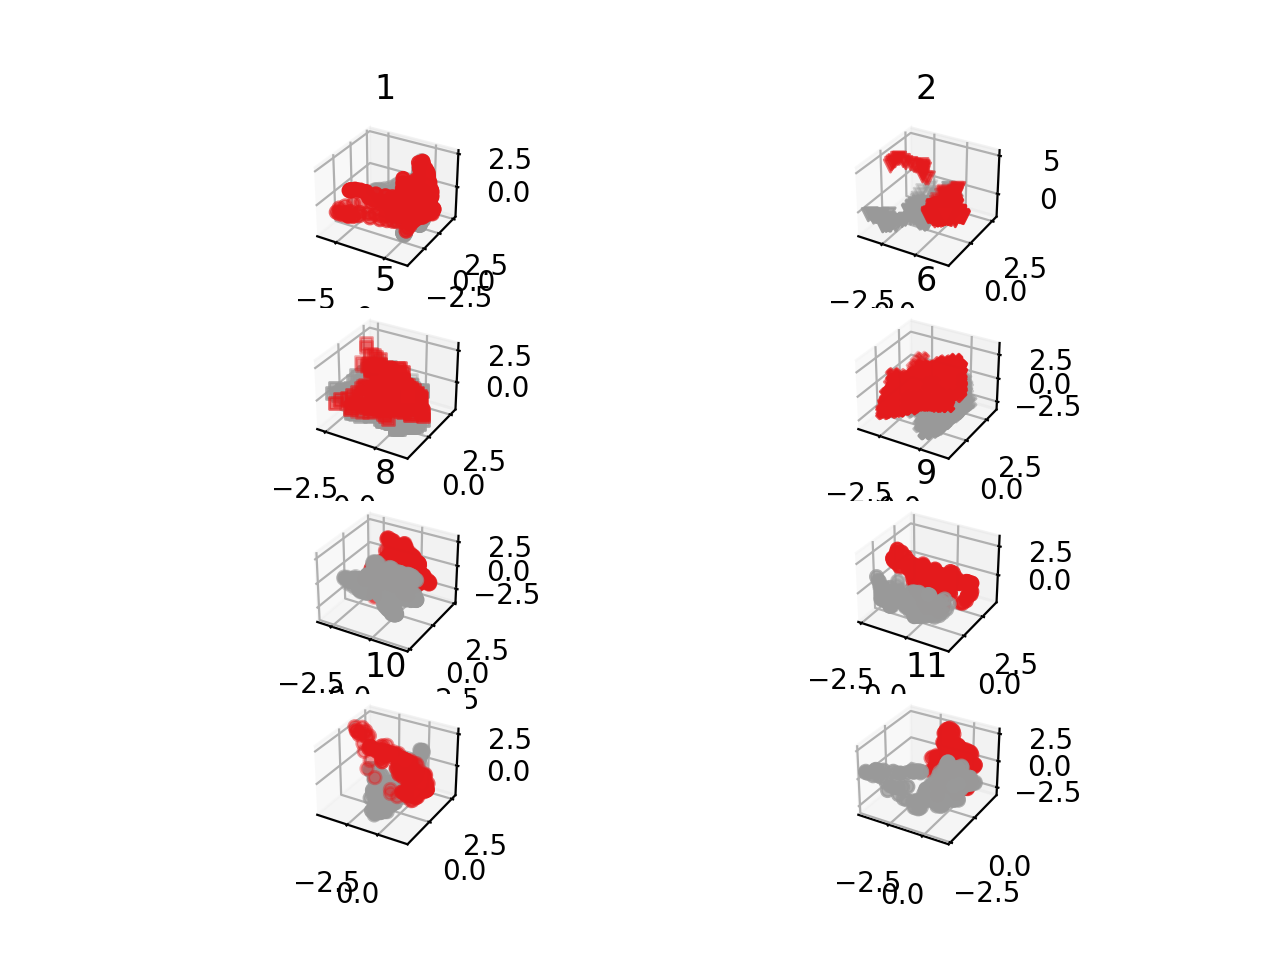

In [27]:
start_dim = 0

plt.figure()
#ax = plt.axes(projection='3d')

for s_i, s_n in enumerate(latents.keys()):
    ax = plt.subplot(4,2, s_i+1, projection='3d')
    plot_latents = latents[s_n]['latents_o']
    plot_labels = fit_labels_conc[s_n]
    
    for sp, sp_lbl in label_map.items():
        sp_clr = subperiod_clrs[sp]
        sp_inds = plot_labels == sp_lbl
        ax.scatter(plot_latents[sp_inds,start_dim+0], plot_latents[sp_inds,start_dim+1], 
                   plot_latents[sp_inds,start_dim+2], color=sp_clr, marker=subject_markers[s_n])
    plt.title(str(s_n))

## Visualize loading matrices across space

In [32]:
vis_comp = 0

In [33]:
_, _, o_vis = svd(prior_lm_conc, full_matrices=False)

In [34]:
mode_imgs = dict()
for s_n in subjects:
    neuron_locs_n = neuron_locs[s_n]#.numpy()[:,[0,1]].astype('float')
    
    lm_n = fit_posteriors[s_n].lm_post(neuron_locs_n).detach().numpy()
    lm_n = np.matmul(lm_n, o_vis.transpose())
    
    mode_imgs[s_n], _ = max_project_pts(dot_positions=neuron_locs_n.numpy()[:,[0,1]].astype('float'),
                                        dot_vls=lm_n[:,vis_comp], 
                                        box_position=np.asarray([[0, 0], [990, 610]]), 
                                        n_divisions=np.asarray([990, 610]), 
                                        dot_dim_width=np.asarray([5,5]))
    
    

<IPython.core.display.Javascript object>


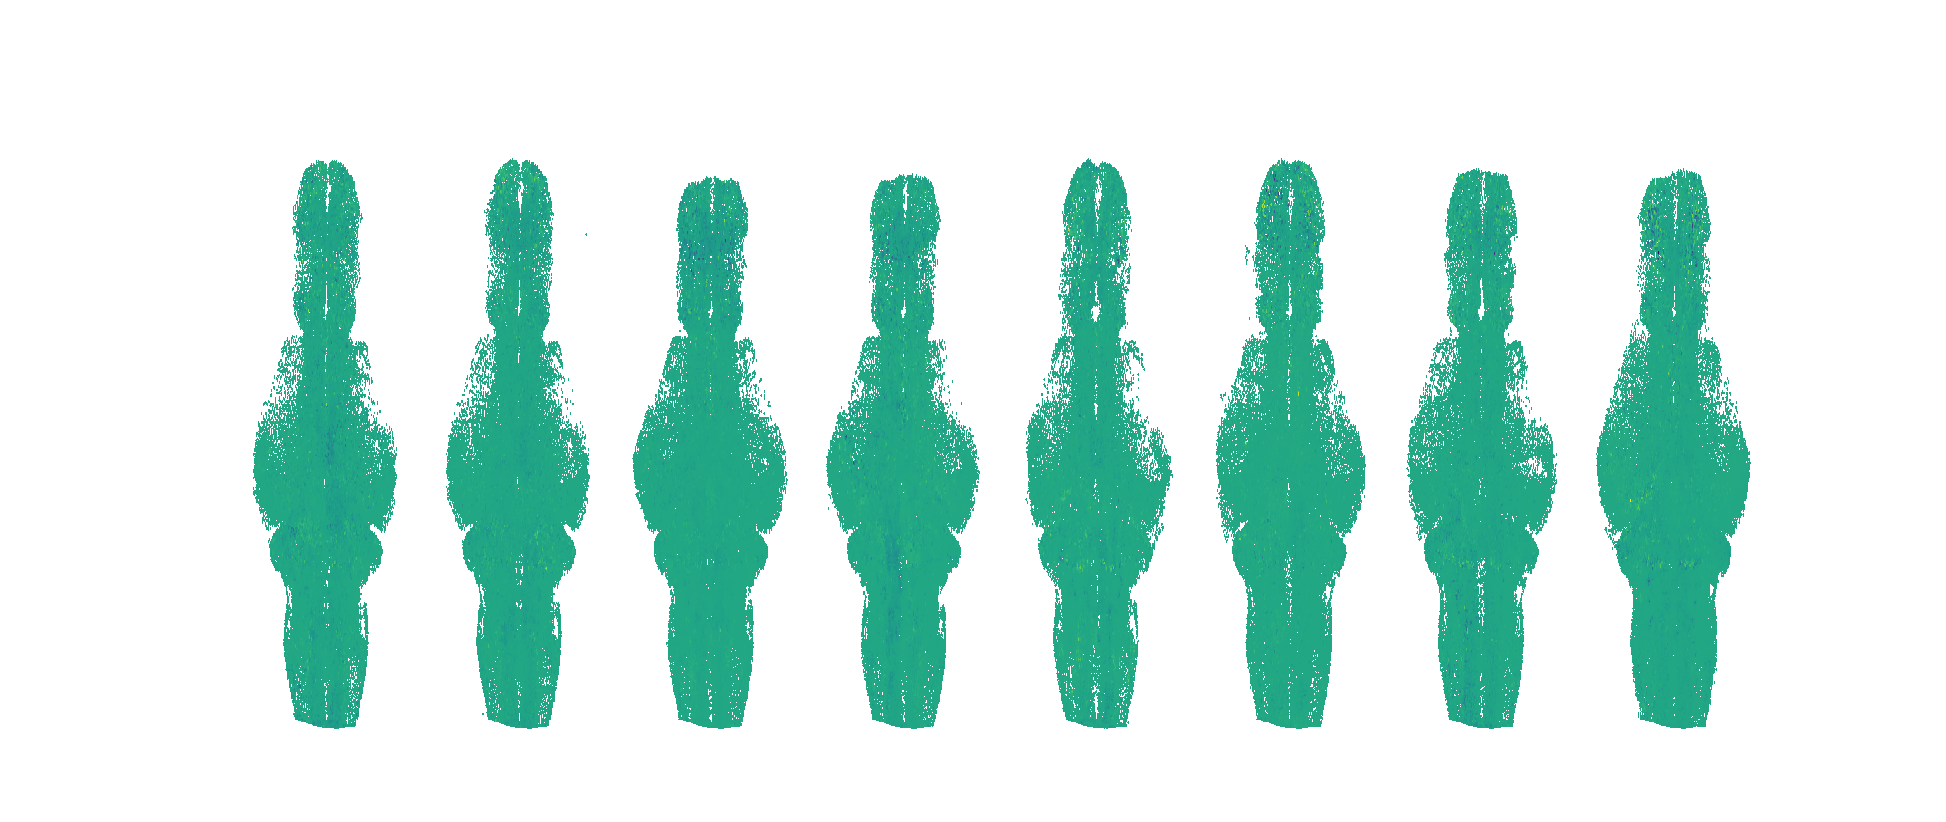

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

In [35]:
plt.figure()
cmp_n_mats([mode_imgs[k] for k in mode_imgs.keys()])